In [ ]:
# Cell 1: Install Kaggle API and authenticate
!pip install kaggle

# Upload your Kaggle API token (kaggle.json) from your local machine
from google.colab import files
files.upload()  # Use this to upload kaggle.json

# Set permissions for the Kaggle API key
!chmod 600 kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
# Cell 2: Download the dataset
!kaggle datasets download -d abhikjha/imdb-wiki-faces-dataset
!unzip imdb-wiki-faces-dataset.zip -d imdb_wiki_data

Streaming output truncated to the last 5000 lines.
  inflating: imdb_wiki_data/imdb_crop/98/nm2140098_rm221349888_1987-8-30_2005.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2140098_rm238127104_1987-8-30_2005.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2140098_rm254904320_1987-8-30_2005.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2140098_rm3246080_1987-8-30_2005.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2140098_rm357599232_1987-8-30_2005.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2140098_rm4266559488_1987-8-30_2005.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2141398_rm743622144_1981-10-15_2014.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2171898_rm1728443392_1982-1-16_2011.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2171898_rm1903294208_1982-1-16_2015.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2171898_rm4126077440_1982-1-16_2015.jpg  
  inflating: imdb_wiki_data/imdb_crop/98/nm2171898_rm4149856000_1982-1-16_2014.jpg  
  inflating: imdb_wik

In [ ]:
# Cell 3: Install required packages
!pip install torch torchvision pandas pillow scikit-learn scipy matplotlib


In [ ]:
# Cell 4: Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error


# Inspect the structure of imdb.mat
from scipy.io import loadmat

metadata_path = 'imdb_wiki_data/imdb_crop/imdb.mat'
metadata = loadmat(metadata_path)

# Display keys at the top level
print(metadata.keys())

# Display the structure of the 'imdb' key (this usually contains the relevant data)
print(metadata['imdb'].dtype)

# Display the fields within 'imdb'
print(metadata['imdb'][0, 0].dtype)



dict_keys(['__header__', '__version__', '__globals__', 'imdb'])
[('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]
[('dob', 'O'), ('photo_taken', 'O'), ('full_path', 'O'), ('gender', 'O'), ('name', 'O'), ('face_location', 'O'), ('face_score', 'O'), ('second_face_score', 'O'), ('celeb_names', 'O'), ('celeb_id', 'O')]


In [ ]:
# Cell 5: Load and process metadata with age calculation

from datetime import timedelta, datetime

# Corrected function to handle Matlab's serial date format
def matlab_datenum_to_datetime(matlab_datenum):
    try:
        matlab_base_date = datetime(1, 1, 1)
        delta = timedelta(days=int(matlab_datenum) - 366)
        converted_date = matlab_base_date + delta

        # Check if the date is within a reasonable range (year > 1900)
        if converted_date.year > 1900:
            return converted_date
        else:
            return None
    except (OverflowError, ValueError):
        return None

# Load the .mat file
metadata_path = 'imdb_wiki_data/imdb_crop/imdb.mat'
metadata = loadmat(metadata_path)

# Extract relevant fields
file_paths = [f[0] for f in metadata['imdb'][0, 0]['full_path'][0]]
dob = metadata['imdb'][0, 0]['dob'][0]
photo_taken = metadata['imdb'][0, 0]['photo_taken'][0]

# Calculate ages with error handling for dates
ages = []
for dob_val, photo_year in zip(dob, photo_taken):
    if dob_val > 0:
        birth_date = matlab_datenum_to_datetime(dob_val)
        if birth_date is not None:
            age = max(0, photo_year - birth_date.year)
            ages.append(age)
        else:
            ages.append(None)
    else:
        ages.append(None)

# Create DataFrame and sample subset
data = pd.DataFrame({'file_name': file_paths, 'age': ages})
data = data.dropna()
data['age'] = data['age'].astype(int)
sample_data = data.sample(70000, random_state=42)

# Split sample_data into training and validation sets
train_df, val_df = train_test_split(sample_data, test_size=0.2, random_state=42)

print("Sample data with ages:\n", sample_data.head())


Sample data with ages:
                                             file_name  age
326429   90/nm0940990_rm314738176_1984-12-17_2010.jpg   26
378716   65/nm1668265_rm2087489280_1980-5-18_2010.jpg   30
223486   25/nm1411125_rm3095629312_1992-7-22_2009.jpg   17
177790  32/nm0005532_rm3635394048_1967-10-13_2007.jpg   40
13424   38/nm0000138_rm2017433600_1974-11-11_2004.jpg   30


<ipython-input-5-a1c271cd35a2>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age'] = data['age'].astype(int)


In [ ]:
# Cell 6: Define dataset and data loading with reduced batch size

class IMDBWIKIDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx]['file_name'])
        image = Image.open(img_name).convert('RGB')
        age = self.df.iloc[idx]['age']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)

# Define transforms with data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split data and create DataLoader with reduced batch size
train_df, val_df = train_test_split(sample_data, test_size=0.2, random_state=42)
train_dataset = IMDBWIKIDataset(train_df, img_dir='imdb_wiki_data/imdb_crop/', transform=transform)
val_dataset = IMDBWIKIDataset(val_df, img_dir='imdb_wiki_data/imdb_crop/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
# Cell 7: Define model, loss, optimizer, and scheduler with additional adjustments

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model with updated method for loading pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Increased dropout rate
    nn.Linear(model.fc.in_features, 1)  # Modify the last layer for regression
)
model = model.to(device)

# Update criterion, optimizer, and add a learning rate scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Reduced learning rate and added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  # Removed verbose

# Function to print learning rate
def print_lr(optimizer):
    for param_group in optimizer.param_groups:
        print("Current learning rate:", param_group['lr'])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [ ]:
# Cell 8: Training and validation functions
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, ages in loader:
        images, ages = images.to(device), ages.to(device).view(-1, 1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def validate_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, ages in loader:
            images, ages = images.to(device), ages.to(device).view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, ages)
            running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)


In [ ]:
# Cell 9: Initialize lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop with loss tracking
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate_epoch(model, val_loader, criterion)

    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Print learning rate after scheduler step
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print_lr(optimizer)  # Print the current learning rate

    # Early stopping criteria could be checked here if still required

print("Training complete.")


Epoch [1/10], Train Loss: 472.3476, Val Loss: 136.9422
Current learning rate: 0.0001
Epoch [2/10], Train Loss: 131.1049, Val Loss: 125.0961
Current learning rate: 0.0001
Epoch [3/10], Train Loss: 123.7400, Val Loss: 123.7259
Current learning rate: 0.0001
Epoch [4/10], Train Loss: 119.4109, Val Loss: 121.7823
Current learning rate: 0.0001
Epoch [5/10], Train Loss: 115.2957, Val Loss: 123.4015
Current learning rate: 0.0001
Epoch [6/10], Train Loss: 111.6773, Val Loss: 123.9945
Current learning rate: 0.0001
Epoch [7/10], Train Loss: 107.6783, Val Loss: 121.6840
Current learning rate: 0.0001
Epoch [8/10], Train Loss: 103.2142, Val Loss: 131.5465
Current learning rate: 0.0001
Epoch [9/10], Train Loss: 98.9991, Val Loss: 123.6764
Current learning rate: 0.0001
Epoch [10/10], Train Loss: 94.3407, Val Loss: 126.0478
Current learning rate: 0.0001
Training complete.


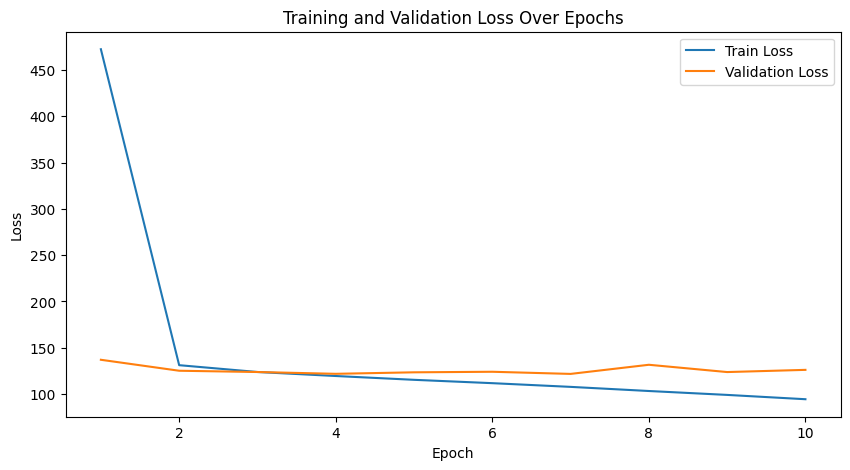

In [ ]:
# Cell 10: Plot training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
# Cell 11: Evaluate the model with MAE
def evaluate_model(model, loader):
    model.eval()
    true_ages = []
    predicted_ages = []
    with torch.no_grad():
        for images, ages in loader:
            images = images.to(device)
            outputs = model(images).cpu().squeeze()
            true_ages.extend(ages.numpy())
            predicted_ages.extend(outputs.numpy())
    mae = mean_absolute_error(true_ages, predicted_ages)
    return mae

# Calculate Mean Absolute Error on the validation set
val_mae = evaluate_model(model, val_loader)
print(f"Validation Mean Absolute Error: {val_mae:.2f}")


Validation Mean Absolute Error: 8.19


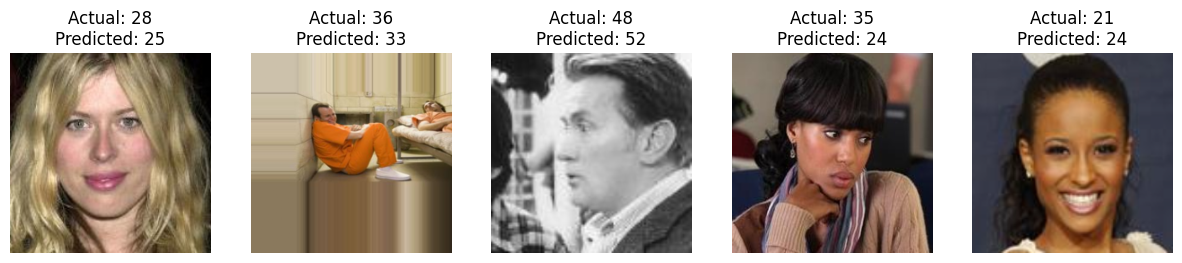

In [ ]:
# Cell 12: Display Actual and Predicted Ages
def display_predictions(model, loader, num_examples=5):
    model.eval()
    images, actual_ages, predicted_ages = [], [], []
    with torch.no_grad():
        for i, (img_batch, age_batch) in enumerate(loader):
            if i >= num_examples:  # Limit the number of examples shown
                break
            img_batch = img_batch.to(device)
            outputs = model(img_batch).cpu().squeeze()
            images.extend(img_batch.cpu())
            actual_ages.extend(age_batch.numpy())
            predicted_ages.extend(outputs.numpy())

    fig, axs = plt.subplots(1, num_examples, figsize=(15, 5))
    for i in range(num_examples):
        img = images[i].permute(1, 2, 0)  # Reorder dimensions for display
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Denormalize
        img = img.numpy().clip(0, 1)  # Convert to numpy and clip to valid range

        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"Actual: {int(actual_ages[i])}\nPredicted: {int(predicted_ages[i])}")
    plt.show()

# Run the function to display predictions
display_predictions(model, val_loader)
